In [5]:
import lightning as L
import torchvision
import torch

from model.lightning_model import LightningModel
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
from model.resnet import resnet32

In [6]:
with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg)

{'params': {'max_epochs': 20, 'batch_size': 128, 'learning_rate': 0.005, 'num_workers': 8, 'seed': 7, 'optimizer': 'sgd', 'momentum': 0.9, 'weight_decay': 0.0005, 'model': 'resnet32', 'accelerator': 'auto', 'num_nodes': 1, 'logger': 'wandb_logger', 'dm': 'CIFAR10', 'wandb_project': 'mlml', 'wandb_name': 'resnet32,epochs=20,lr=0.005,bs=128', 'data_dir': './data/cifar10', 'num_classes': 10}}


In [7]:
path = (
    "./resnet32,epochs=20,lr=0.005,bs=128/y31wvz1z/checkpoints/epoch=2-step=1053.ckpt"
)

In [8]:
lightning_model = LightningModel.load_from_checkpoint(path)

CifarResNet : Depth : 32 , Layers for each block : 5


In [9]:
from data_loader.CIFAR10 import CIFAR10

L.pytorch.seed_everything(42)
dm = CIFAR10(batch_size=64, data_path="./data/cifar10/")
dm.prepare_data()
dm.setup()

Seed set to 42


Files already downloaded and verified


In [10]:
trainer = L.Trainer(
    max_epochs=cfg.params.max_epochs,
    accelerator=cfg.params.accelerator,
    num_nodes=cfg.params.num_nodes,
)
trainer.test(lightning_model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ubuntu/anaconda3/envs/venv_312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.

Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/anaconda3/envs/venv_312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 74.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7491999864578247
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.7491999864578247}]

In [11]:
from torchattacks import PGD

atk = PGD(lightning_model, eps=8 / 255, alpha=2 / 225, steps=10, random_start=True)
atk.set_mode_targeted_by_label()
print(atk)

Attack mode is changed to 'targeted(label)'.
PGD(model_name=LightningModel, device=cpu, attack_mode=targeted(label), targeted=True, normalization_used=False, eps=0.03137254901960784, alpha=0.008888888888888889, steps=10, random_start=True)


In [19]:
# take one batch of data from dm
images, labels = next(iter(dm.test_dataloader()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(3)


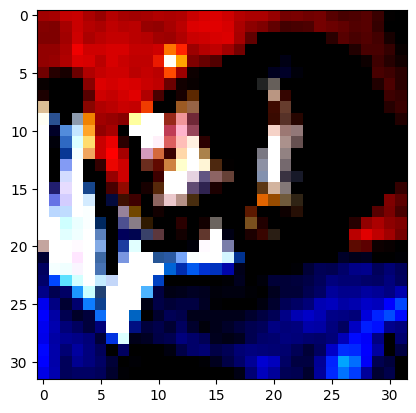

In [20]:
# visualize image[0]
import matplotlib.pyplot as plt

plt.imshow(images[0].permute(1, 2, 0))
print(labels[0])
plt.show()

In [22]:
print(labels)
new_labels = (labels + 1) % 10
print(new_labels)

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3])
tensor([4, 9, 9, 1, 7, 7, 2, 7, 4, 2, 1, 0, 6, 8, 0, 9, 6, 8, 9, 7, 8, 1, 5, 0,
        6, 3, 5, 1, 0, 7, 7, 6, 5, 6, 0, 3, 5, 2, 0, 6, 5, 7, 6, 7, 1, 0, 4, 0,
        8, 7, 0, 9, 1, 4, 9, 9, 8, 8, 5, 7, 8, 4, 7, 4])


In [24]:
adv_images = atk(images, new_labels)
adv_pred = lightning_model(adv_images)
print(labels)
print(torch.argmax(adv_pred, 1))

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3])
tensor([3, 8, 9, 8, 6, 5, 1, 4, 7, 1, 0, 7, 5, 7, 9, 8, 5, 7, 0, 6, 4, 0, 3, 9,
        4, 3, 4, 4, 9, 6, 4, 5, 4, 3, 9, 3, 4, 9, 9, 5, 0, 6, 2, 4, 0, 9, 5, 9,
        7, 4, 0, 9, 0, 3, 8, 8, 7, 0, 5, 3, 4, 4, 0, 0])


In [27]:
from torchmetrics import Accuracy

Accuracy(task="multiclass", num_classes=10)(adv_pred, new_labels)

tensor(0.1094)

In [28]:
pred = lightning_model(images)
Accuracy(task="multiclass", num_classes=10)(pred, labels)

tensor(0.7812)